In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [6]:
n_NS = len(genome)
n_p = 4600
n_r = 15
ep_wt = -3
er_wt = -15

### Varying bin sizes

In [7]:
df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

In [8]:
def plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list):
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data,
                                                    promoter, nbins, upper_bound,
                                                    smoothed=True, windowsize=3)
    
    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
    ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                            18,
                                            max(footprint) * 0.2,
                                            facecolor='#D56C55',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    plt.show()

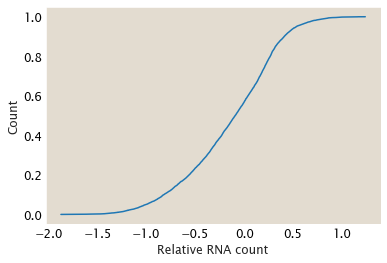

In [9]:
fig, ax = plt.subplots()
#ax.hist(np.log10(mu_data[mu_data > 0]))
ax.plot(np.sort(np.log10(mu_data[mu_data > 0])), np.arange(len(mu_data[mu_data > 0]))/len(mu_data[mu_data > 0]))
#ax.set_yscale('log')
ax.set_xlabel('Relative RNA count')
ax.set_ylabel('Count')
plt.show()

Bin boundary: 1
size of bin 1: 6794; size of bin 2: 3206


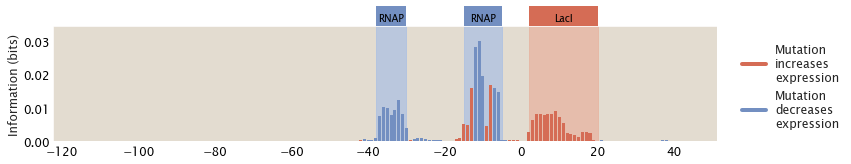

In [10]:
nbins = 2
upper_bound = 1
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 0.8912138353884126
size of bin 1: 6508; size of bin 2: 3492


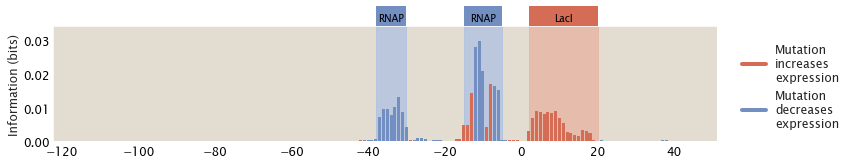

In [11]:
nbins = 2
upper_bound = np.mean(mu_data)
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 0.712760334437124
size of bin 1: 5976; size of bin 2: 4024


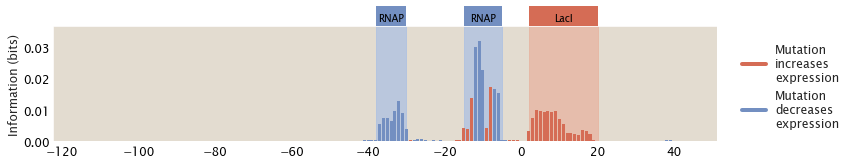

In [12]:
nbins = 2
upper_bound = np.exp(np.mean(np.log(mu_data[mu_data > 0])))
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 4.456069176942063
size of bin 1: 9791; size of bin 2: 209


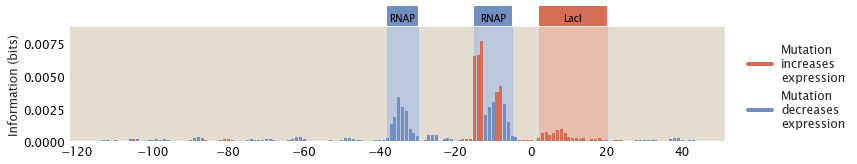

In [13]:
nbins = 2
upper_bound = np.mean(mu_data) * 5
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 0.4456069176942063
size of bin 1: 4917; size of bin 2: 5083


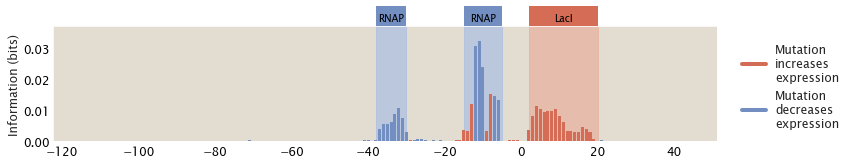

In [14]:
nbins = 2
upper_bound = np.mean(mu_data) * 0.5
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 0.23011479057248552
size of bin 1: 3797; size of bin 2: 6203


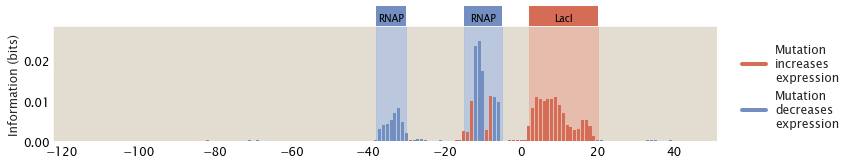

array([0.3797, 0.6203])

In [15]:
nbins = 2
upper_bound = np.median(mu_data) * 0.5
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

all_mutarr = tregs.footprint.match_seqs(promoter, mut_list)
list_joint_p = tregs.footprint.get_joint_p(all_mutarr, mu_bins, nbins, pseudocount=10**(-6), len_promoter=160)
np.sum(list_joint_p[0], axis=0)